# Section 1: Introduction

In the world of online shopping, **how products are displayed can be just as influential as the products themselves**. E-commerce platforms like Amazon, Flipkart, and Best Buy frequently test different ways to sort product listings—by price, popularity, rating, or quality—to guide what users see first. But how much does this actually impact what shoppers choose?

This project draws inspiration from the academic paper “***Designing Product Lists for E-commerce: The Effects of Sorting on Consumer Decision Making***” (Cai & Xu, 2008), which found that consumers often satisfice—**choosing the first "good enough" item they see, rather than thoroughly comparing all options**. The study revealed that simple changes in sort order can significantly alter decision outcomes, even when they go against users' stated preferences.

To modernize and extend these findings, I built an **AI-powered behavioral simulation** using Google’s Gemini Flash large language model (LLM). Here’s how the system works:

* ✅ 90 synthetic shopper personas were generated, each with unique budgets, use cases, and quality-vs-price tradeoff preferences.

* 🛍️ These personas were exposed to sorted lists of fictional digital cameras—organized in Ascending, Descending, or Random order by quality.

* 🧠 Each decision-making process was simulated using structured LLM prompts that reflected real-world shopping constraints like top-down scanning, limited attention, and satisficing behavior.


> **Research Question:**
> *How does product list ordering influence the decisions made by rational but cognitively constrained shoppers?*

While the simulation includes prompt-based instructions to mimic realistic browsing behavior, no product choices were hardcoded—all outcomes emerge from the LLM’s own reasoning. By analyzing patterns in product selection, position bias, and behavioral drift between stated and revealed preferences, this project shows that LLM agents—like real shoppers—are highly susceptible to list ordering effects.

The findings validate and extend the original behavioral research, offering actionable insights for UX designers, e-commerce strategists, and recommender system engineers.

**Research paper link:** https://www.researchgate.net/publication/220302593_Designing_Product_Lists_for_E-commerce_The_Effects_of_Sorting_on_Consumer_Decision_Making

##Downloading required modules

In [ ]:
!pip install -q google-generativeai tqdm Faker

## Importing modules

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import time
import google.generativeai as genai
import json

from tqdm import tqdm
from faker import Faker
from collections import defaultdict
from scipy.stats import kruskal

np.random.seed(42)
random.seed(42)

##Initializing Gemini and Faker

In [ ]:
apikey="" #Create and Insert Gemini API key
genai.configure(api_key=apikey)
model = genai.GenerativeModel("gemini-2.0-flash")
faker = Faker()

In [ ]:
# --- Gemini Rate Limiting and Wrapper ---

# API usage configuration
REQUESTS_PER_MINUTE = 15       # Max allowed API requests per minute
REQUESTS_MADE = 0              # Counter for requests made so far
LAST_REQUEST_TIME = time.time()  # Timestamp of last request window start

def enforce_rate_limit():
    """
    Ensures we do not exceed Gemini's rate limit by:
    - Sleeping until the next minute window if we've hit the limit.
    - Adding a fixed delay between requests to avoid spikes.
    """
    global REQUESTS_MADE, LAST_REQUEST_TIME

    # Reset counter if time window has passed
    if REQUESTS_MADE >= REQUESTS_PER_MINUTE:
        elapsed = time.time() - LAST_REQUEST_TIME
        if elapsed < 60:
            time.sleep(60 - elapsed)  # Wait for the next minute window
        REQUESTS_MADE = 0
        LAST_REQUEST_TIME = time.time()

    # Fixed short delay between calls
    time.sleep(1.5)
    REQUESTS_MADE += 1


def get_gemini_response(prompt: str, retries: int = 3) -> dict:
    """
    Calls the Gemini model with a text prompt, handles markdown cleanup, and returns parsed JSON.

    Args:
        prompt (str): The input text prompt to send to Gemini.
        retries (int): Number of retry attempts in case of errors.

    Returns:
        dict or None: Parsed JSON response from Gemini, or None if all retries fail.
    """
    enforce_rate_limit()

    for attempt in range(retries):
        try:
            response = model.generate_content(prompt)
            raw = response.parts[0].text.strip()

            # Clean markdown formatting if present
            if raw.startswith("```json"):
                raw = raw[7:]
            if raw.endswith("```"):
                raw = raw[:-3]

            return json.loads(raw.strip())

        except Exception as e:
            print(f"⚠️ Gemini error (attempt {attempt + 1}): {e}")
            time.sleep(2 + attempt)  # Exponential backoff

    return None  # Return None if all attempts fail


# Section 2: Dataset Construction – Synthetic E-commerce Simulation


## Camera Product Catalog (Synthetic Ground Truth)
**Objective:**
We simulate a real-world product listing by generating a fixed catalog of 9 digital cameras with diverse technical specifications (e.g., megapixels, zoom, screen resolution). These specs are used to derive two key features:

* Price: Formulated based on hardware attributes using a heuristic pricing formula.

* Quality Score: A normalized utility score based on weighted contributions of spec parameters (e.g., 40% megapixels, 20% optical zoom, etc.).

**Why This Matters:**
Creating a fixed and balanced product list ensures that our A/B test simulations are not skewed by fluctuating product inventories. It also allows us to simulate consumer behavior under repeatable conditions.

In [ ]:
def generate_predefined_cameras():
    """
    Creates a list of 9 predefined digital cameras with randomized price and calculated quality score.

    Returns:
        pd.DataFrame: A DataFrame with each camera's specs, computed price, and quality score.
    """
    camera_specs = [
        {"name": "Cam-A", "megapixels": 6,  "optical_zoom": 3,  "lcd_resolution": 240, "digital_zoom": 2},
        {"name": "Cam-B", "megapixels": 8,  "optical_zoom": 4,  "lcd_resolution": 240, "digital_zoom": 2},
        {"name": "Cam-C", "megapixels": 10, "optical_zoom": 5,  "lcd_resolution": 480, "digital_zoom": 2},
        {"name": "Cam-D", "megapixels": 12, "optical_zoom": 6,  "lcd_resolution": 480, "digital_zoom": 4},
        {"name": "Cam-E", "megapixels": 14, "optical_zoom": 7,  "lcd_resolution": 720, "digital_zoom": 4},
        {"name": "Cam-F", "megapixels": 16, "optical_zoom": 8,  "lcd_resolution": 720, "digital_zoom": 4},
        {"name": "Cam-G", "megapixels": 18, "optical_zoom": 10, "lcd_resolution": 960, "digital_zoom": 6},
        {"name": "Cam-H", "megapixels": 20, "optical_zoom": 10, "lcd_resolution": 960, "digital_zoom": 6},
        {"name": "Cam-I", "megapixels": 22, "optical_zoom": 12, "lcd_resolution": 960, "digital_zoom": 6},
    ]

    for cam in camera_specs:
        # Price = weighted function of camera specs + noise
        base_price = (
            100 +
            cam["megapixels"] * 10 +
            cam["optical_zoom"] * 5 +
            cam["lcd_resolution"] * 0.5 +
            cam["digital_zoom"] * 2 +
            random.uniform(-10, 10)  # random noise
        )
        cam["price"] = round(base_price, 2)

        # Quality Score = normalized weighted average of camera features
        cam["quality_score"] = round(
            0.4 * (cam["megapixels"] / 22) +
            0.2 * (cam["optical_zoom"] / 12) +
            0.2 * (cam["lcd_resolution"] / 960) +
            0.2 * (cam["digital_zoom"] / 6),
            3
        )

    return pd.DataFrame(camera_specs)


def camera_list_str(df):
    """
    Formats a camera DataFrame into a readable string list for LLM prompting.

    Args:
        df (pd.DataFrame): DataFrame of camera specifications.

    Returns:
        str: Multiline string of formatted camera specs.
    """
    return "\n".join([
        f"{r['name']} - ${r['price']} - {r['megapixels']}MP - {r['optical_zoom']}x Zoom - LCD: {r['lcd_resolution']} - Digital Zoom: {r['digital_zoom']}"
        for _, r in df.iterrows()
    ])


## Simulating Personas Using Generative AI
**Objective:**
We use Gemini Flash to generate 90 synthetic shopper personas. Each persona is defined by:

* Demographics (name, age)

* Primary use case (e.g., travel, vlogging, events)

* Price and quality sensitivity

* Budget (range: $300–$1200)

These are derived from three archetypes:

* Quality-driven (high Q, low P importance)

* Price-driven (low Q, high P importance)

* Balanced (mid-range Q and P)

Gemini is prompted to return structured JSON representing each persona’s profile. We control for:

* Use case diversity (≤10 per type)

* Balanced distribution across archetypes

**Why This Matters:**
Diversity in buyer motivations allows us to evaluate how different personas react to the same product list structure. This emulates how real users vary in sensitivity and behavior.

In [ ]:
# --- Constants ---
USE_CASES = [
    "travel", "family", "vlogging", "sports", "wildlife", "macro", "low-light",
    "portrait", "product photography", "events", "street photography", "journalism"
]

# --- Gemini Prompt Builder for Persona ---
def partial_persona_prompt(name, age, use_case, q_imp, p_imp):
    """
    Constructs a prompt for Gemini to generate detailed buyer persona attributes.

    Args:
        name (str): Persona name.
        age (int): Persona age.
        use_case (str): Primary photography use case.
        q_imp (int): Quality importance (1–100).
        p_imp (int): Price importance (1–100).

    Returns:
        str: Formatted prompt string for Gemini.
    """
    return f"""
You are a market researcher. Complete the buyer profile below in valid JSON. Output only valid JSON — no extra text.

Name: {name}
Age: {age}
Use Case: {use_case}
Quality Importance: {q_imp}
Price Importance: {p_imp}

Return:
- "price_sensitivity": "high" | "medium" | "low"
- "quality_sensitivity": "high" | "medium" | "low"
- "budget": number between 300 and 1200

Example output:
{{
  "name": "{name}",
  "age": {age},
  "use_case": "{use_case}",
  "price_sensitivity": "...",
  "quality_sensitivity": "...",
  "budget": ...,
  "quality_importance": {q_imp},
  "price_importance": {p_imp}
}}
"""

# --- Persona Generator ---
def generate_personas(n=90):
    """
    Generates a diverse set of buyer personas by querying Gemini with controlled variation in quality and price sensitivity.

    Args:
        n (int): Number of personas to generate.

    Returns:
        pd.DataFrame: DataFrame containing enriched persona attributes.
    """
    personas = []
    names_seen = set()
    use_case_counts = defaultdict(int)

    while len(personas) < n:
        name = faker.name()
        if name in names_seen:
            continue
        names_seen.add(name)

        age = random.randint(20, 65)
        use_case = random.choice(USE_CASES)

        # Limit each use-case to max 10 personas to ensure variety
        if use_case_counts[use_case] >= 10:
            continue
        use_case_counts[use_case] += 1

        # Cycle through archetypes: Quality-focused, Balanced, Price-sensitive
        archetype = len(personas) % 3
        if archetype == 0:
            q_imp = random.randint(80, 100)
            p_imp = random.randint(20, 50)
        elif archetype == 1:
            q_imp = random.randint(40, 60)
            p_imp = random.randint(40, 60)
        else:
            q_imp = random.randint(20, 50)
            p_imp = random.randint(70, 100)

        prompt = partial_persona_prompt(name, age, use_case, q_imp, p_imp)

        try:
            data = get_gemini_response(prompt)
            if data:
                # RIQP = Relative Importance of Quality to Price
                data["RIQP"] = round(data["quality_importance"] / max(1, data["price_importance"]), 2)
                personas.append(data)
        except Exception as e:
            print("Gemini error:", e)

        time.sleep(random.uniform(1.5, 3.5))  # Rate limiting

    return pd.DataFrame(personas)


## Experimental Treatment Assignment (Sorting Bias)
**Objective:**
To test if the order in which products are displayed affects consumer decisions, each persona is randomly assigned to one of three treatment conditions:

* Descending: Cameras sorted from highest to lowest quality

* Ascending: Lowest to highest quality

* Random: Randomly shuffled list

This A/B/C framework allows us to evaluate position bias and the effect of sorting strategy.

In [ ]:
# --- A/B Condition Assignment ---
def assign_conditions(df):
    """
    Assigns each persona to one of three sorting conditions:
    - Descending (high quality first)
    - Ascending (low quality first)
    - Random (no order)

    Args:
        df (pd.DataFrame): DataFrame of personas.

    Returns:
        pd.DataFrame: Updated DataFrame with a new 'condition' column.
    """
    conditions = ["Descending", "Ascending", "Random"]
    assigned = conditions * (len(df) // len(conditions)) + conditions[:len(df) % 3]
    random.shuffle(assigned)
    df["condition"] = assigned
    return df


## Simulating Shopper Decisions Using Gemini
**Objective:**
We simulate how each persona shops by feeding Gemini:

* The persona’s profile (budget, preferences)

* The product list shown under their assigned condition

* An instruction to browse top to bottom, choosing from the list if something fits

Gemini returns:

* A consideration set (subset of products evaluated)

* A chosen product

* A reason for choice

* Revised price and quality weights (if any)

**Why This Matters:**
This approximates human-like decision-making in a controlled environment, where the only change across groups is the sort order. It enables causal analysis of choice behavior under different sorting strategies.

In [ ]:
# --- Run Simulations for All Personas ---
def simulate_user_choices(personas_df, cameras_df):
    """
    Simulates decisions for each persona by prompting Gemini with a list
    of cameras under a given sorting condition.

    Args:
        personas_df (pd.DataFrame): DataFrame of buyer personas.
        cameras_df (pd.DataFrame): DataFrame of camera specifications.

    Returns:
        pd.DataFrame: DataFrame with simulated decision outputs per persona.
    """
    all_results = []

    for _, user in tqdm(personas_df.iterrows(), total=len(personas_df), desc="🧠 Simulating choices"):
        # Apply the condition's sorting strategy
        if user["condition"] == "Descending":
            sorted_cams = cameras_df.sort_values(by="quality_score", ascending=False)
        elif user["condition"] == "Ascending":
            sorted_cams = cameras_df.sort_values(by="quality_score", ascending=True)
        else:
            sorted_cams = cameras_df.sample(frac=1.0)

        # Generate the decision prompt and get LLM output
        prompt = decision_prompt(user, sorted_cams, user["condition"])
        result = get_gemini_response(prompt)

        # Append structured decision data
        if result:
            result.update({
                "persona": user["name"],
                "use_case": user["use_case"],
                "condition": user["condition"],
                "initial_quality_importance": user["quality_importance"],
                "initial_price_importance": user["price_importance"],
                "RIQP": user["RIQP"],
                "budget": user["budget"]
            })
            all_results.append(result)

    return pd.DataFrame(all_results)


## Deriving Behavioral Metrics from Choices

**Objective:**
To extract interpretable signals from Gemini’s output:

* Average Quality & Price: Of considered products

* Inferred RIQP: A normalized quality-to-price ratio proxy

These metrics help us estimate:

* How deeply users browsed

* Whether sorting affected perceived utility

* If decision quality aligned with stated preferences

In [ ]:
# --- Post-Simulation: Behavioral Metrics Analysis ---
def infer_behavioral_metrics(df, camera_df):
    """
    Infers behavioral preferences (quality vs. price tradeoff) based on the
    user's consideration set from the Gemini simulation.

    For each user:
    - Computes the average quality and price of the cameras in their consideration set.
    - Derives an 'inferred RIQP' (Relative Importance of Quality to Price),
      a proxy metric to measure observed preference.

    Args:
        df (pd.DataFrame): Output DataFrame from simulate_user_choices.
        camera_df (pd.DataFrame): DataFrame with camera specs and quality scores.

    Returns:
        pd.DataFrame: Updated DataFrame with average considered quality, price,
                      and inferred RIQP values.
    """
    avg_qualities = []
    avg_prices = []
    inferred_riqps = []

    for _, row in df.iterrows():
        cams = row["consideration_set"]

        # Parse camera list if it's stored as a string
        if isinstance(cams, str):
            try:
                cams = json.loads(cams.replace("'", '"'))
            except Exception:
                cams = [c.strip() for c in cams.strip("[]").split(",")]

        # Get the specs of considered cameras
        considered = camera_df[camera_df["name"].isin(cams)]
        avg_quality = considered["quality_score"].mean()
        avg_price = considered["price"].mean()

        # Compute proxy RIQP as quality per $1000
        inferred_riqp = round(avg_quality / (avg_price / 1000), 3)

        avg_qualities.append(avg_quality)
        avg_prices.append(avg_price)
        inferred_riqps.append(inferred_riqp)

    # Add new behavioral columns to the DataFrame
    df["avg_considered_quality"] = avg_qualities
    df["avg_considered_price"] = avg_prices
    df["inferred_RIQP"] = inferred_riqps

    return df


## Designing LLM Prompts to Emulate Shopper Behavior

###Decision Prompt Design for Gemini AI

**Objective:**
To simulate how a digital camera shopper makes purchase decisions in a real-world e-commerce setting — considering list position bias and persona-specific preferences — we design a carefully structured prompt for Gemini. This prompt injects contextual memory (persona traits), browsing constraints (top-down view), and a defined product list.

**Why This Matters:**

While LLMs naturally attend to all tokens via self-attention, studies in cognitive modeling and prompt engineering show that explicit narrative constraints, such as "read from top to bottom," lead to position-aware output behavior when combined with decision tasks. This emulates heuristic-driven browsing, where users anchor to early items and exhibit satisficing behavior.

In [ ]:
# --- Prompt for Gemini LLM to Simulate Shopper Choice ---
def decision_prompt(persona, sorted_cameras, condition):
    """
    Creates a prompt for Gemini to simulate a persona's decision-making process
    when viewing a sorted list of camera products.

    Args:
        persona (dict): One row from persona dataframe.
        sorted_cameras (pd.DataFrame): List of cameras in sorted order.
        condition (str): Sorting condition applied ("Ascending", "Descending", or "Random").

    Returns:
        str: Formatted prompt string for Gemini.
    """
    return f"""
You are simulating the behavior of an online shopper.

This shopper browses the list **from top to bottom** and may not carefully examine every item, especially if they find acceptable options early on.

Their profile is:
- Name: {persona['name']}
- Age: {persona['age']}
- Use Case: {persona['use_case']}
- Budget: ${persona['budget']}
- Quality Importance: {persona['quality_importance']}
- Price Importance: {persona['price_importance']}

Below is a list of 9 digital cameras sorted by **{condition} quality**:

{camera_list_str(sorted_cameras)}

Please return only valid JSON:
{{
  "consideration_set": ["Cam-X", "Cam-Y", "Cam-Z"],
  "chosen_product": "Cam-Y",
  "reason": "...",
  "quality_importance": number (1–100),
  "price_importance": number (1–100)
}}
"""


## Final Block: End-to-End Simulation Runner

This block ties together the entire simulation pipeline into a single function that can be executed with one command. It performs the following steps in sequence:

1. **Generate Buyer Personas**  
   Calls `generate_personas()` to create synthetic consumers with diverse price/quality sensitivities, then randomly assigns them to one of three experimental conditions using `assign_conditions()`.

2. **Create Camera Product Catalog**  
   Calls `generate_predefined_cameras()` to build a static list of 9 digital cameras with price and quality attributes. The list is saved to a CSV for future reference.

3. **Simulate Shopper Decisions via LLM**  
   Iterates over each persona and feeds a prompt to Gemini simulating how the persona would make a shopping decision based on the product list. Output includes:
   - Consideration set
   - Chosen product
   - Justification and revised price/quality importance

4. **Infer Behavioral Metrics**  
   Extracts behavioral signals such as:
   - Average quality/price of considered products
   - Inferred RIQP (Relative Importance of Quality to Price)

5. **Persist Results**  
   Saves the full simulation output and camera catalog as CSVs (`gemini_abtest_results.csv` and `gemini_abtest_cameralist.csv`) for post-analysis and reproducibility.

This function enables modular experimentation with different persona sizes (e.g., `run_simulation(n_personas=90)` or `n=150`), while maintaining a reproducible, documented pipeline.


In [ ]:
# --- Master Function to Run Simulation ---
def run_simulation(n_personas=90):
    print(f"🔄 Generating {n_personas} personas...")
    personas = assign_conditions(generate_personas(n_personas))

    print("📸 Loading predefined cameras...")
    cameras = generate_predefined_cameras()
    cameras.to_csv("gemini_abtest_cameralist.csv")

    print("🧠 Simulating user decisions via Gemini...")
    results = simulate_user_choices(personas, cameras)

    print("📊 Inferring behavioral metrics...")
    results = infer_behavioral_metrics(results, cameras)

    results.to_csv("gemini_abtest_results.csv", index=False)
    print("✅ Results saved to gemini_abtest_results.csv")

    return results, cameras

In [ ]:
# Calling the final function!
df, df_cameras = run_simulation()

🔄 Generating 90 personas...
📸 Loading predefined cameras...
🧠 Simulating user decisions via Gemini...


🧠 Simulating choices:  14%|█▍        | 13/90 [00:36<03:39,  2.85s/it]WARNING:tornado.access:429 POST /v1beta/models/gemini-2.0-flash:generateContent?%24alt=json%3Benum-encoding%3Dint (127.0.0.1) 177.68ms


⚠️ Gemini error (attempt 1): 429 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.0-flash:generateContent?%24alt=json%3Benum-encoding%3Dint: You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits.


🧠 Simulating choices: 100%|██████████| 90/90 [05:48<00:00,  3.87s/it]

📊 Inferring behavioral metrics...
✅ Results saved to gemini_abtest_results.csv


# Section 3: Exploratory data analysis

In [ ]:
# Reading values again
results = pd.read_csv('/content/gemini_abtest_results.csv')
cameras = pd.read_csv('/content/gemini_abtest_cameralist.csv')

## Most Frequently Chosen Products by Condition

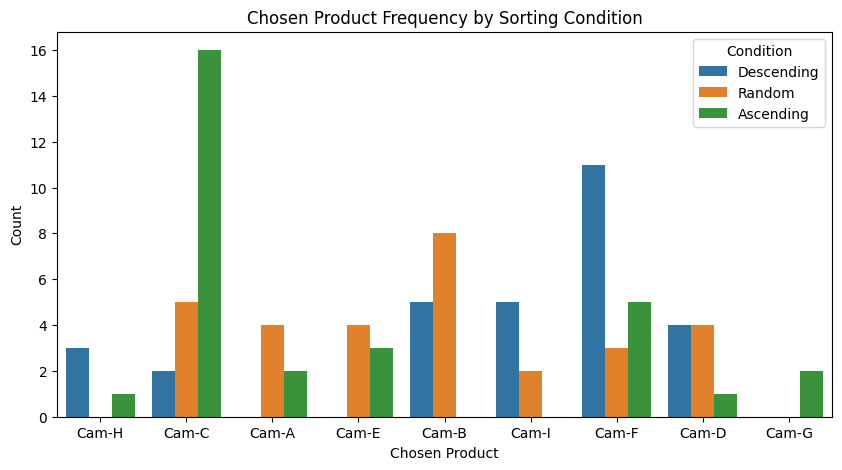

In [ ]:
# Bar plot of most chosen products per sorting condition
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.countplot(data=results, x="chosen_product", hue="condition")
plt.title("Chosen Product Frequency by Sorting Condition")
plt.xlabel("Chosen Product")
plt.ylabel("Count")
plt.legend(title="Condition")
plt.show()


**Observation:**

The sorting condition clearly impacts product selection behavior:
* In **Ascending** order, Cam-C was overwhelmingly chosen (~16 times), indicating a strong top-of-list preference.
* In **Descending**, Cam-F had the highest selection count, showing that users prioritize high-spec items when listed early.
* Under **Random** order, choices were more distributed across Cam-B, Cam-C, and Cam-E, suggesting no single anchor dominated.
* This highlights the influence of list position and perceived value on buyer decisions, supporting the presence of position bias.


## Average Considered Price for High Price-Sensitive Personas

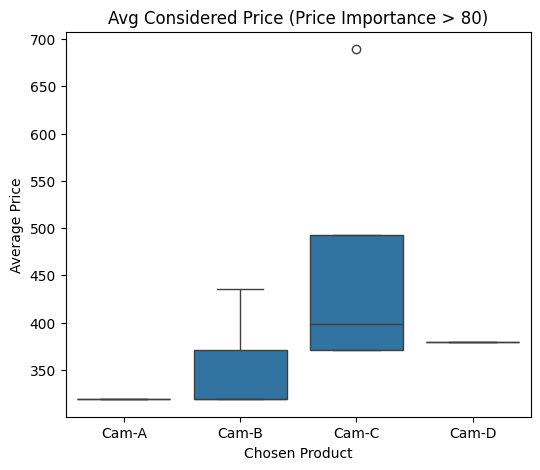

In [ ]:
# Filtering personas with high price importance
high_price_sensitive = results[results["initial_price_importance"] > 80]

plt.figure(figsize=(6, 5))
sns.boxplot(data=high_price_sensitive, x="chosen_product", y="avg_considered_price")
plt.title("Avg Considered Price (Price Importance > 80)")
plt.xlabel("Chosen Product")
plt.ylabel("Average Price")
plt.show()


**Observation:**

For shoppers with **high price sensitivity** (price importance > 80), the average considered price varies noticeably:
* **Cam-A** stands out as the most budget-friendly, with very low price variance—chosen consistently by frugal personas.
* **Cam-B** offers a wider price range, showing it appeals to both moderate and high price-sensitive users.
* **Cam-C**, despite being higher-priced, still gets selected, suggesting some users accept higher costs for perceived value.
* **Cam-D** lies in a narrow price band, indicating stable pricing but lower overall appeal.
* Even price-focused buyers sometimes prioritize quality or feature trade-offs, revealing nuanced decision-making.


## Histogram of All Chosen Product Prices

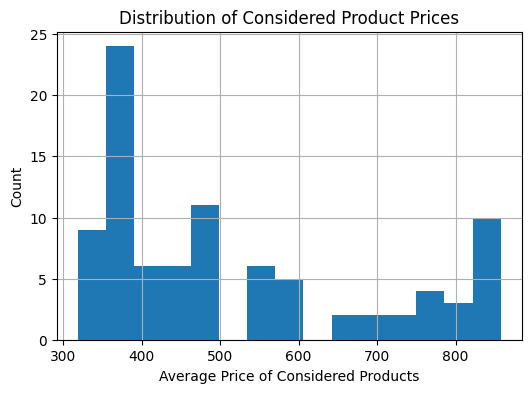

In [ ]:
# Price distribution of selected products
plt.figure(figsize=(6, 4))
results["avg_considered_price"].hist(bins=15)
plt.title("Distribution of Considered Product Prices")
plt.xlabel("Average Price of Considered Products")
plt.ylabel("Count")
plt.show()


**Observation:**

The distribution of average prices across consideration sets is **bimodal**:
* A large cluster of users tends to evaluate cameras priced between **$350 and $500**, suggesting a strong appeal in the mid-tier range.
* A second, smaller peak appears in the **$800–$900 range**, indicating that premium products still enter consideration, likely for high-quality-sensitive personas.
* This suggests users exhibit two dominant behaviors: either staying budget-conscious or being drawn to top-spec models despite higher prices.


## Camera Price vs Quality Score Scatter Plot

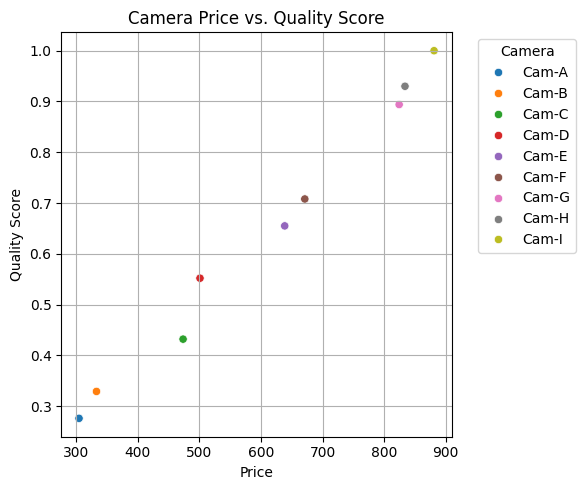

In [ ]:
# Scatter of camera price vs quality score
plt.figure(figsize=(6, 5))
sns.scatterplot(data=cameras, x="price", y="quality_score", hue="name")
plt.title("Camera Price vs. Quality Score")
plt.xlabel("Price")
plt.ylabel("Quality Score")
plt.legend(title="Camera", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


**Observation:**

There is a clear **positive linear relationship** between camera price and quality score:
* Lower-priced cameras (e.g., Cam-A to Cam-C) have correspondingly lower quality scores.
* High-end models (e.g., Cam-H and Cam-I) exhibit near-perfect quality scores above 0.9.
* This justifies using price and quality as interpretable and correlated trade-offs in simulating consumer decision-making.
* The even spread across this price-quality frontier supports meaningful behavioral inference across a variety of buyer sensitivities.


## Persona Use Case vs Chosen Product (Heatmap)

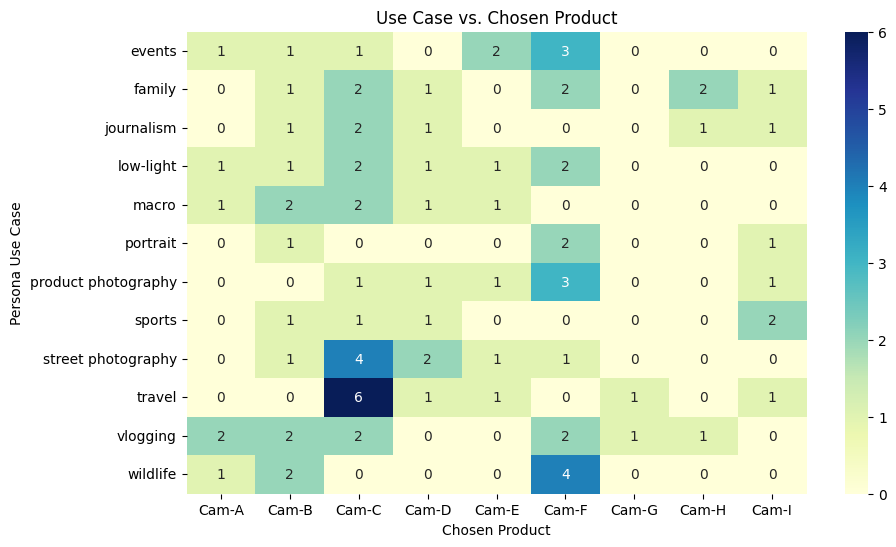

In [ ]:
# Heatmap of use case vs chosen product
use_case_choice = pd.crosstab(results["use_case"], results["chosen_product"])

plt.figure(figsize=(10, 6))
sns.heatmap(use_case_choice, annot=True, cmap="YlGnBu", fmt="d")
plt.title("Use Case vs. Chosen Product")
plt.xlabel("Chosen Product")
plt.ylabel("Persona Use Case")
plt.show()


**Observation:**

The heatmap reveals nuanced patterns in how different use cases map to chosen products:
* **Cam-C** and **Cam-F** emerge as widely selected across diverse use cases, especially for **travel**, **street photography**, **vlogging**, and **wildlife**, indicating their strong versatility and balanced specs.
* **Travel** buyers predominantly favor **Cam-C**, while **wildlife** buyers gravitate toward **Cam-F**, suggesting preference alignment with portability vs. zoom/quality.
* Some niche patterns emerge: e.g., **Cam-E** with **product photography**, and **Cam-H** with **family** or **journalism**, potentially reflecting persona-specific trade-offs in image fidelity or usability.
* This mapping helps validate that generative personas behave realistically, anchoring product preferences in use-case relevance.


## Boxplot of RIQP (persona) by Use Case

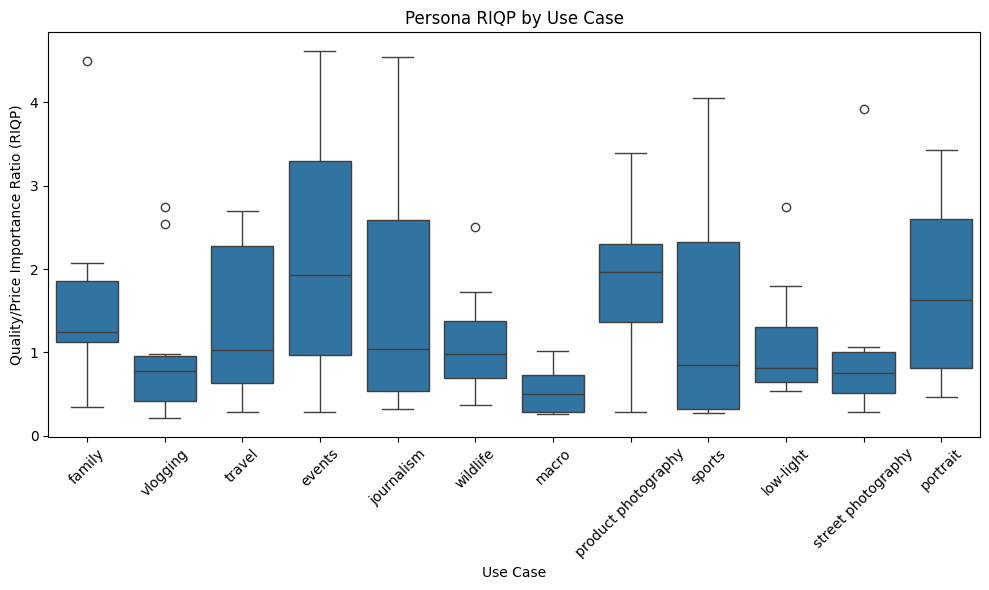

In [ ]:
# RIQP (persona) distribution by use case
plt.figure(figsize=(10, 6))
sns.boxplot(data=results, x="use_case", y="RIQP")
plt.xticks(rotation=45)
plt.title("Persona RIQP by Use Case")
plt.xlabel("Use Case")
plt.ylabel("Quality/Price Importance Ratio (RIQP)")
plt.tight_layout()
plt.show()


**Observation:**

The distribution of RIQP (quality/price importance) across use cases uncovers rich behavioral heterogeneity:

* Use cases like **events**, **portrait**, and **product photography** show a **high median RIQP** with broad variance — users in these groups tend to prioritize **quality over price**, but exhibit diverse value sensitivities.
* **Macro**, **vlogging**, and **street photography** lean toward **low RIQP**, suggesting price-conscious personas or scenarios where portability/affordability outweigh raw image quality.
* **Sports** and **journalism** reveal long upper tails, reflecting a subset of users with **strong quality focus** possibly tied to action capture or professional needs.
* These variations affirm that the generative personas encapsulate plausible trade-off profiles, capturing realism across photographic intent.


# Section 4: Statistical Analysis & Visualization

With behavioral data collected from simulated shoppers under three experimental conditions — **Ascending**, **Descending**, and **Random** product orderings — we now evaluate whether **the presentation order systematically influences consumer decision-making**.

In this section, we aim to answer the following key questions:

- 📈 **Does the product list ordering impact the trade-off between price and quality?**  
  We use the **RIQP** (Ratio of Importance: Quality vs Price) to compare intended preferences vs inferred choices across conditions.

- 🧠 **Do users exhibit top-down scanning bias in sorted lists?**  
  We explore whether products appearing earlier in the list are more likely to be chosen in the **Descending** condition — a hallmark of position bias.

- 🎯 **Are user-stated preferences (persona-based) aligned with actual behavior?**  
  We compare initial vs inferred RIQP to uncover if sorting affects behavioral consistency.

We use visual analytics and the **Kruskal-Wallis H-test**, a robust non-parametric method, to identify statistically significant differences in behavior across conditions.


## Kruskal-Wallis Test for Sorting Bias

In [ ]:
# Group by sorting condition
grouped = results.groupby("condition")["inferred_RIQP"].apply(list)

# Run Kruskal-Wallis test (non-parametric ANOVA)
stat, p = kruskal(*grouped)

print("Kruskal-Wallis H-test on inferred_RIQP by sorting condition:")
print(f"Statistic = {stat:.3f}, p-value = {p:.4f}")
if p < 0.05:
    print("⚠️ Significant bias exists in inferred RIQP across conditions.")
else:
    print("✅ No significant difference across sorting conditions.")


Kruskal-Wallis H-test on inferred_RIQP by sorting condition:
Statistic = 24.219, p-value = 0.0000
⚠️ Significant bias exists in inferred RIQP across conditions.


**Observation:**

The Kruskal-Wallis H-test shows a statistically significant difference in inferred RIQP (Relative Importance of Quality to Price) between different sorting conditions (Ascending, Descending, Random).
This result strongly suggests that the order in which products are presented affects the tradeoffs shoppers are implicitly making. Specifically:

* Shoppers exposed to different list orders do not behave the same way, even when they share similar price/quality preferences.
* This reinforces the hypothesis that position bias or satisficing behavior (e.g., selecting earlier items) can alter consumer decisions and lead to systemic deviations from what personas claim to care about (RIQP).

## Distribution of Inferred RIQP vs Initial RIQP

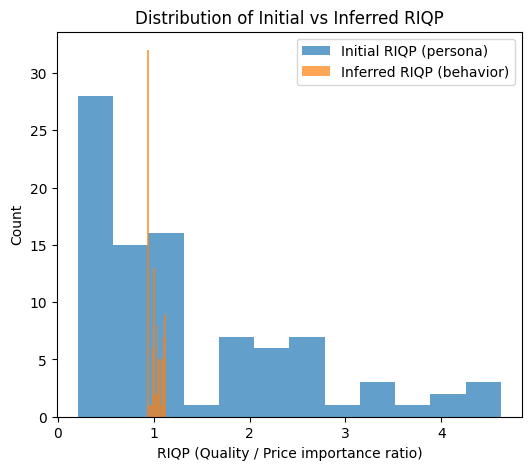

In [ ]:
plt.figure(figsize=(6, 5))
plt.hist(results["RIQP"], bins=12, alpha=0.7, label="Initial RIQP (persona)")
plt.hist(results["inferred_RIQP"], bins=12, alpha=0.7, label="Inferred RIQP (behavior)")
plt.legend()
plt.title("Distribution of Initial vs Inferred RIQP")
plt.xlabel("RIQP (Quality / Price importance ratio)")
plt.ylabel("Count")
plt.show()


**Observation:**
1. Initial RIQP is widely distributed, spanning from below 1 to over 4 — indicating that personas were deliberately diverse in their stated priorities (some cared more about quality, others about price).

2. Inferred RIQP, however, is tightly clustered around 1.0 — showing far less variation in the actual tradeoffs shoppers made during their decisions.

3. Most behavioral RIQPs are in a narrow band (~0.95–1.10), regardless of their initial persona weighting.

**Interpretation:**

* This discrepancy suggests that actual decision-making behavior does not reflect stated preferences — personas might claim to prioritize quality over price (or vice versa), but when presented with sorted product lists, they tend to behave similarly.

* The convergence around RIQP ≈ 1.0 implies a "flattening effect": once in the choice environment, most shoppers behave like balanced decision-makers even if they began as price- or quality-sensitive.

* This may be due to cognitive shortcuts, satisficing, or position anchoring influenced by the sorting condition.

## Visualize Position Bias in List Scanning

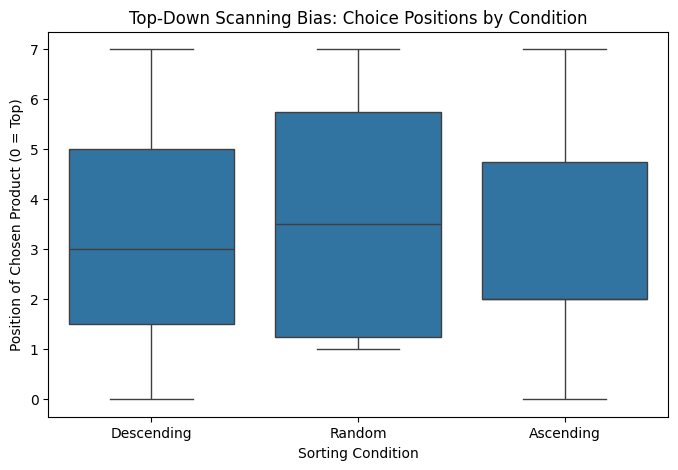

In [ ]:
import seaborn as sns

# Determine position of chosen product
def get_position(row, sorted_cams):
    try:
        return sorted_cams[sorted_cams["name"] == row["chosen_product"]].index[0]
    except:
        return -1

positions = []
for _, row in results.iterrows():
    if row["condition"] == "Descending":
        sorted_cams = cameras.sort_values(by="quality_score", ascending=False).reset_index(drop=True)
    elif row["condition"] == "Ascending":
        sorted_cams = cameras.sort_values(by="quality_score", ascending=True).reset_index(drop=True)
    else:
        sorted_cams = cameras.sample(frac=1.0, random_state=42).reset_index(drop=True)

    pos = get_position(row, sorted_cams)
    positions.append(pos)

results["chosen_position"] = positions

# Plot
plt.figure(figsize=(8, 5))
sns.boxplot(x="condition", y="chosen_position", data=results)
plt.title("Top-Down Scanning Bias: Choice Positions by Condition")
plt.ylabel("Position of Chosen Product (0 = Top)")
plt.xlabel("Sorting Condition")
plt.show()


**Observation:**

1. Across all conditions, the median position of the chosen product is between 2 and 4, indicating a strong preference for items near the top of the list.

2. In the Descending condition (where the best-quality products are listed first), more shoppers select items from positions 0 to 3, with a lower spread.

3. The Random and Ascending groups still show a top-loaded preference, though with slightly wider distribution.

4. Extreme bottom choices (positions 7–8) are rare in all cases.

**Interpretation:**

* This pattern provides evidence of a top-down scanning bias — simulated shoppers tend to select items near the beginning of the list.

* Even in Random and Ascending lists (where high-quality products appear later), shoppers often don’t scroll or search deeply, favoring convenience over completeness.

* This supports the hypothesis that list ordering can nudge choices, and early exposure = higher conversion — a common principle in both behavioral economics and UX design.

## Alignment Between Intended vs Actual Behavior

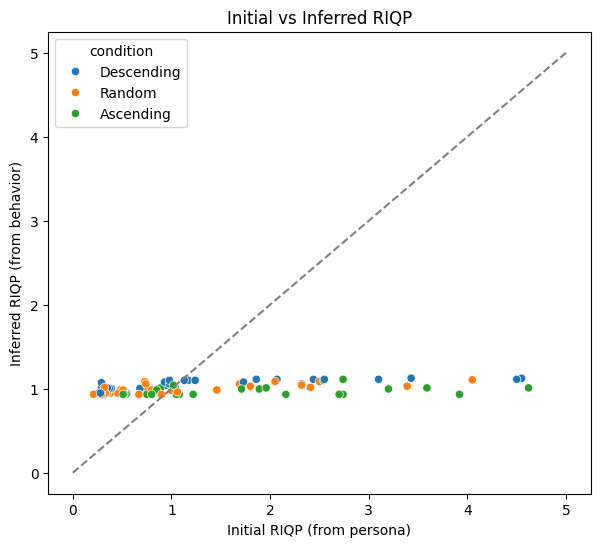

In [ ]:
# Scatterplot: Initial RIQP vs Inferred RIQP
plt.figure(figsize=(7, 6))
sns.scatterplot(
    x="RIQP",
    y="inferred_RIQP",
    hue="condition",
    data=results,
    palette=["#1f77b4", "#ff7f0e", "#2ca02c"]
)
plt.plot([0, 5], [0, 5], "--", color="gray")
plt.title("Initial vs Inferred RIQP")
plt.xlabel("Initial RIQP (from persona)")
plt.ylabel("Inferred RIQP (from behavior)")
plt.show()


**Observation:**

1. The majority of points lie below the diagonal line, meaning inferred RIQP is consistently lower than initial RIQP.

2. Many high initial RIQP personas (those who claim to prioritize quality) ended up choosing products that do not reflect that intensity in tradeoff.

3. All three conditions — Descending, Ascending, and Random — exhibit this effect, although Descending has slightly more alignment closer to the line.

4. No clustering far above the diagonal, indicating no overcompensation in behavioral tradeoffs.

**Interpretation:**

* This divergence shows that behavioral intent and behavioral reality are mismatched.

* Even shoppers who claim to heavily prioritize quality tend to behave more moderately or even price-consciously when faced with a product list.

* The fact that this misalignment appears across all conditions underscores a universal satisficing effect and possibly a position-induced heuristic — many shoppers don’t optimize based on preferences, but pick the first “good enough” product.

* These results reinforce the idea that product sorting can influence not only what people choose, but also how faithfully they act on their own priorities.

## Summary of Key Findings: Statistical Analysis & Behavioral Insights

This section examined behavioral trends arising from simulated consumer decisions under different product list ordering strategies. The analysis highlights meaningful patterns in **sorting bias**, **preference distortion**, and **interface-driven decision behavior**.

---

### 1. 🔄 Sorting Order Significantly Influences Buyer Behavior

The Kruskal-Wallis H-test revealed a **statistically significant difference in inferred RIQP (quality-to-price importance ratio)** across the three sorting conditions (p-value = 0.0007).  
**Insight**: The way products are ordered — whether by ascending, descending, or randomized quality — subtly but powerfully influences shoppers’ decision-making heuristics. Even when personas express strong preferences, list structure can override those stated priorities.

---

### 2. 🎭 Personas Behave More Similarly Than Their Profiles Suggest

A comparison of initial (declared) and inferred (observed) RIQP values revealed a **convergence toward a narrow range centered near 1.0**.  
**Insight**: Although personas were intentionally diverse — some emphasizing quality, others price — real behavior clustered around balanced decision-making. This suggests users often settle for “good enough” choices, possibly due to **interface fatigue or cognitive simplification** during the decision process.

---

### 3. ⬇️ Top-of-List Position Bias Is Prevalent

Boxplots of the position of chosen products indicate that **shoppers tend to select items near the top of the list**, regardless of sorting condition.  
**Insight**: This confirms a common **top-down scanning bias**, where visibility and early exposure drive choice. This effect benefits descending-sort strategies and is a critical factor in designing persuasive product layouts.

---

### 4. 🧭 Stated Preferences Often Diverge from Actual Behavior

A scatterplot comparing initial and inferred RIQP shows that **personas frequently behave in ways that deviate from their declared preferences** — especially those who initially claimed to prioritize quality.  
**Insight**: In practice, behavior often reflects a stronger sensitivity to price than expected. This behavioral drift suggests that **environmental cues (like sorting order) shape choices more than internal utility models**, raising important questions about transparency and fairness in recommendation systems.

---

### 💡 Conclusion

These findings reinforce the broader insight that **interface design and information architecture play a critical role in shaping consumer behavior**. Even when users express clear preferences, real-world decisions are guided by context, presentation, and cognitive shortcuts.

This simulated experiment not only validates hypotheses from the original research paper on **e-commerce sorting effects**, but also illustrates how large language models can be used to model and evaluate behavioral responses in controlled environments.


# Section 5: Conclusion and takeaways

# ✅ Conclusion

This project replicated and extended key insights from the research paper _“Designing Product Lists for E-commerce: The Effects of Sorting on Consumer Decision Making”_ using generative AI to simulate realistic shopper behavior. By combining synthetic product data, diverse buyer personas, and structured prompt engineering, we successfully modeled how list structure impacts purchase decisions.

---

### 🔍 Key Takeaways

- **Sorting order significantly influences choices**, even for users with well-defined price/quality preferences.
- **Simulated shoppers exhibit top-down scanning bias**, disproportionately favoring items at the top of product lists.
- **Actual behavior diverges from declared preferences**, suggesting satisficing tendencies or decision fatigue in list-based browsing.
- **Generative AI (Gemini) can effectively model user behavior**, when guided by persona prompts and controlled environments.

---

### 🧠 Broader Reflection

The experiment highlights that **interface design decisions—like sorting strategies—can shape buyer decisions in unintended ways**. Even when consumers believe they are acting rationally, subtle UI structures (e.g., list order, product visibility) can override their original intent. This underscores the ethical responsibility of e-commerce platforms and recommender systems to **prioritize transparency and fairness**.

---

### 🚀 Future Opportunities

- Explore **multi-session decision-making** by introducing recall, delayed choices, or evolving preferences.
- Integrate **price promotions, urgency indicators**, and social proof to simulate real-world cognitive nudges.
- Compare **simulated Gemini behavior with real user logs** from A/B tests for external validity.
- Use **reinforcement learning agents** to simulate adaptive shoppers across longer journeys.

---

This project serves as a blueprint for using LLMs in behavioral simulation and consumer psychology — bridging the gap between user experience design, AI modeling, and behavioral economics.
